In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import seaborn as sns
from pneumoniacnn import PneumoniaCNN
import utils as uti

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [2]:
# Set paths
data_dir = '../data/chest_xray'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# Define transforms
train_transform, test_transform, __ =  uti.transform_imgs()

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=test_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [3]:
# Class distribution
train_counts = uti.count_class_dist(train_dataset)

# Calculate class weights for imbalanced dataset
class_weights = torch.FloatTensor([len(train_dataset)/train_counts[0], len(train_dataset)/train_counts[1]]).to(device)

Training set - Normal: 1341, Pneumonia: 3875
Class weights - Normal: 3.889634601043997, Pneumonia: 1.3460645161290323


In [4]:
# Initialize model
model = PneumoniaCNN()
model = model.to(device)
print(model)

model_name = 'pneumonia_cnn_model'

PneumoniaCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=25088, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


In [5]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)  # Using weighted loss for imbalanced classes
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

# Train the model
model = uti.train_model(model, train_dataset, train_loader, val_dataset, val_loader, \
                        criterion, optimizer, scheduler, model_name, device, num_epochs=10)

# Save the model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'class_names': train_dataset.classes,
}, 'cnn/' + model_name + '.pth')

print("Model saved successfully!")

Epoch 1/10
----------
Train Loss: 0.6912 Acc: 0.8886
Val Loss: 1.0301 Acc: 0.7500
Saved best model!
Epoch 2/10
----------
Train Loss: 0.1423 Acc: 0.9477
Val Loss: 0.8106 Acc: 0.7500
Saved best model!
Epoch 3/10
----------
Train Loss: 0.1256 Acc: 0.9513
Val Loss: 0.8402 Acc: 0.6875
Epoch 4/10
----------
Train Loss: 0.1322 Acc: 0.9517
Val Loss: 0.2524 Acc: 0.8750
Saved best model!
Epoch 5/10
----------
Train Loss: 0.1209 Acc: 0.9557
Val Loss: 0.7620 Acc: 0.7500
Epoch 6/10
----------
Train Loss: 0.1107 Acc: 0.9605
Val Loss: 0.3864 Acc: 0.7500
Epoch 7/10
----------
Train Loss: 0.0985 Acc: 0.9649
Val Loss: 1.4859 Acc: 0.6250
Epoch 8/10
----------
Train Loss: 0.0776 Acc: 0.9703
Val Loss: 0.3135 Acc: 0.8750
Epoch 9/10
----------
Train Loss: 0.0694 Acc: 0.9741
Val Loss: 0.5185 Acc: 0.8750
Epoch 10/10
----------
Train Loss: 0.0788 Acc: 0.9689
Val Loss: 0.3398 Acc: 0.7500
Training complete in 18m 10s
Model saved successfully!



Test Set Performance Metrics:
Accuracy: 0.8446
Precision: 0.8415
Recall: 0.9256
F1 Score: 0.8816


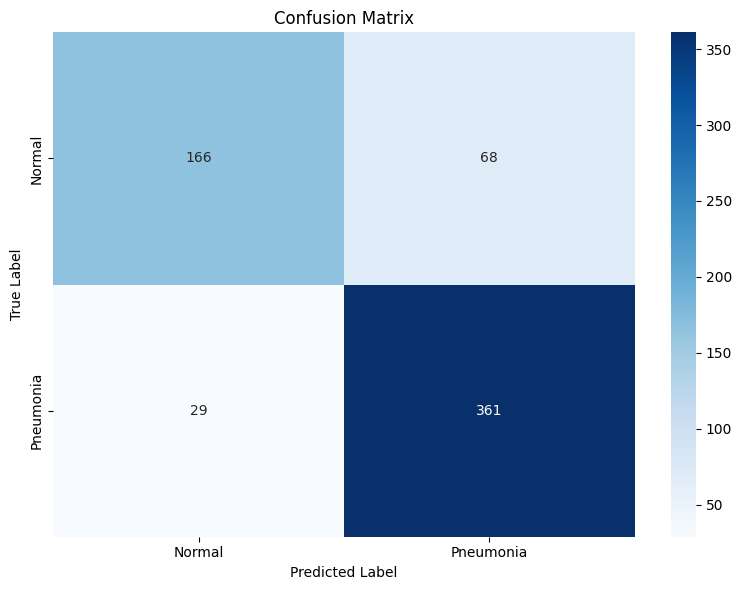

In [6]:
# Evaluate on test set
test_metrics = uti.evaluate_model(model, test_loader, device, model_name)